In [1]:
from download import *
from databuilder import *
from dataset import *
from processing import *

from torchvision import transforms
import torch.nn as nn

from ResNet import resnet
from MobileNet import MobileNetV2
from EfficientNet import efficientnet

import funcs

df = download_mimii("../../data/mimii", "0_dB")

../../data/mimii/0_dB/fan.zip already exist.
../../data/mimii/0_dB/fan.zip already extracted.
../../data/mimii/0_dB/pump.zip already exist.
../../data/mimii/0_dB/pump.zip already extracted.
../../data/mimii/0_dB/slider.zip already exist.
../../data/mimii/0_dB/slider.zip already extracted.
../../data/mimii/0_dB/valve.zip already exist.
../../data/mimii/0_dB/valve.zip already extracted.


In [2]:
params = {
    "batch_size":32,
    "epoch": 5,
    "learning_rate": 0.0001,
    "path": "./saved/resnet/ephoc5"
}

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [3]:
# df["label"].value_counts()
df["label"].value_counts().sort_index()

0    14719
1     1475
2      456
3      890
4      479
Name: label, dtype: int64

In [4]:
train_df, val_df, test_df = split_dataframe(df, 0.6, 0.2)
# print(train_df.shape)
# print(train_df)

In [5]:
train_data, train_label = build_from_dataframe(train_df, 4096, 4096//2, False)
val_data, val_label = build_from_dataframe(val_df, 4096, 4096//2, False)
test_data, test_label = build_from_dataframe(test_df, 4096, 4096//2, False)
# print(train_data.shape)
# print(train_data)

In [6]:
transform = transforms.Compose([
    melspectogram(),
    ExpandDim(),
    ReSize(3, 32, 32),
    NpToTensor()
])

In [7]:
train_dataset = NumpyDataset(data=train_data, label=train_label, 
                             transform=transform, target_transform=NpToTensor())
val_dataset = NumpyDataset(data=val_data, label=val_label, 
                             transform=transform, target_transform=NpToTensor())
test_dataset = NumpyDataset(data=test_data, label=test_label, 
                             transform=transform, target_transform=NpToTensor())

# print(train_dataset.data)
# print(train_dataset.label)

In [8]:
train_loader = get_dataloader(dataset=train_dataset,
                              batch_size=params["batch_size"],
                              shuffle=True)
val_loader = get_dataloader(dataset=val_dataset,
                              batch_size=params["batch_size"],
                              shuffle=False)
test_loader = get_dataloader(dataset=test_dataset,
                              batch_size=params["batch_size"],
                              shuffle=False)

In [9]:
# # 데이터로더 동작 확인
# for i, (data, target) in enumerate(train_loader):
#     print(i, data.shape, target.shape, data[0].shape)
#     if i > 9:
#         break

In [10]:
model = resnet().ResNet18().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

In [11]:
train_acc_list = []
train_loss_list = []

test_acc_list = []
test_loss_list = []

In [12]:
for epoch in range(1, params["epoch"] + 1):
    train_loss, train_accuracy = funcs.train(model, train_loader, optimizer, DEVICE, criterion, params["batch_size"])
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    print("[EPOCH: {}] \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.4f}".format(
        epoch, train_loss, train_accuracy))

    test_loss, test_accuracy = funcs.test(model, test_loader, DEVICE, criterion, params["batch_size"])
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    print("[EPOCH: {}] \tTest Loss: {:.4f}, \tTest Accuracy: {:.4f}\n".format(
        epoch, test_loss, test_accuracy))
    # 에폭당 학습률 확인(필요시)
    # l_r = [x["lr"] for x in optimizer.param_groups]
    # print("lr:{}\n".format(l_r))


[EPOCH: 1] 	Train Loss: 0.3091, 	Train Accuracy: 0.9059
[EPOCH: 1] 	Test Loss: 0.2519, 	Test Accuracy: 0.9219

[EPOCH: 2] 	Train Loss: 0.1999, 	Train Accuracy: 0.9375
[EPOCH: 2] 	Test Loss: 0.2910, 	Test Accuracy: 0.9151

[EPOCH: 3] 	Train Loss: 0.1710, 	Train Accuracy: 0.9464
[EPOCH: 3] 	Test Loss: 0.1843, 	Test Accuracy: 0.9433

[EPOCH: 4] 	Train Loss: 0.1554, 	Train Accuracy: 0.9509
[EPOCH: 4] 	Test Loss: 0.2375, 	Test Accuracy: 0.9257

[EPOCH: 5] 	Train Loss: 0.1444, 	Train Accuracy: 0.9542
[EPOCH: 5] 	Test Loss: 0.1787, 	Test Accuracy: 0.9440



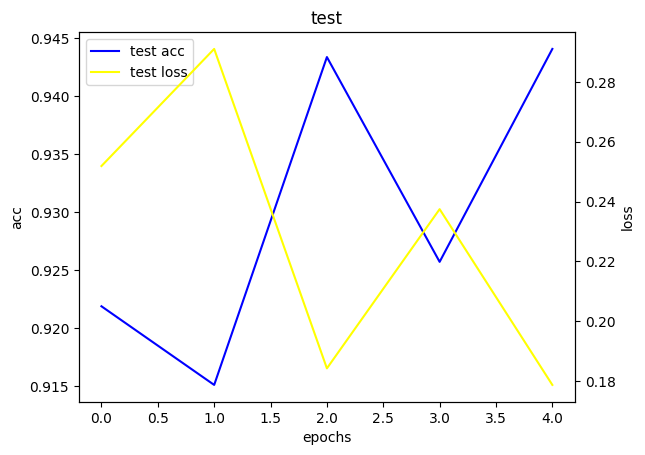

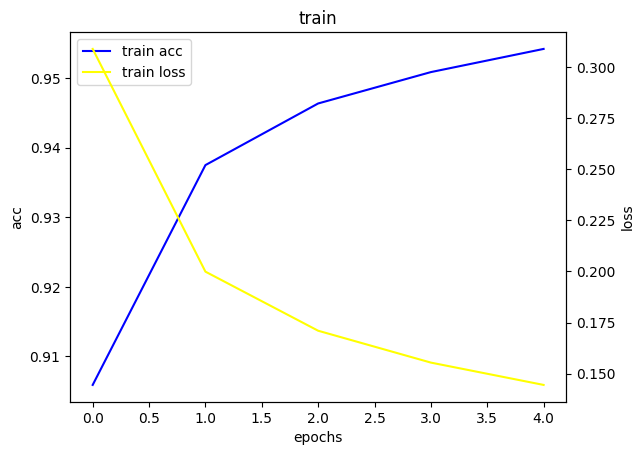

In [13]:
funcs.DrawGraph(test_acc_list, test_loss_list, 'test', mode='test', root=params["path"])
funcs.DrawGraph(train_acc_list, train_loss_list, 'train', mode='train', root=params["path"])

In [14]:
max_test_acc = max(test_acc_list)
print('max_test_acc: ', max_test_acc)

max_test_acc:  0.9440431925031514


In [15]:
# 모델 저장
torch.save(model.state_dict(), f"{params["path"]}/model.pth")

SyntaxError: invalid syntax (1388042881.py, line 2)